In [1]:
import Heston
import BlackScholes
import pandas as pd
import numpy as np
import copy

import datetime
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.optimize import least_squares
import scipy.integrate
import time

In [2]:
S0 = 4017.8
t0 = "23 Jan 2023"

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

r = 0.0291
q = 0.0154
K = moneyness*S0/100

<IPython.core.display.Javascript object>


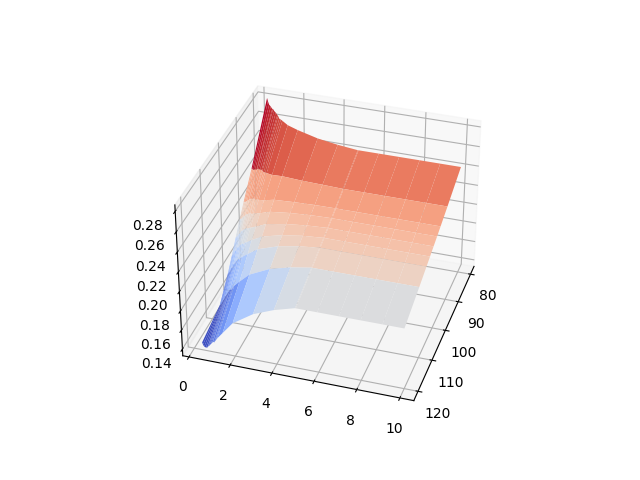

In [32]:
%matplotlib notebook
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
mesh_x, mesh_y = np.meshgrid(moneyness,maturities[30:])
surf = ax.plot_surface(mesh_x, mesh_y, IV[30:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
plt.show()

In [34]:
P = copy.copy(IV)

for j in range(len(maturities)):
    for i in range(len(moneyness)):
        P[j,i] = BlackScholes.BSCall(S0, K[i], maturities[j], r, q, IV[j,i])

P = P.flatten()
L = 18
N = 64
options_type = np.ones(len(K))
N_T = len(maturities)

In [37]:
start_time = time.time()

params = np.array([.2, .5, .2, .3, -.8])
P_cal = np.zeros(N_T*9)
grad = np.zeros((N_T*9,5))

def f(prms):
    sigma_0, kappa,eta, theta, rho = prms
    for i in range(N_T):
        precomp, a, b = Heston.precomputed_terms(r, q, maturities[i], sigma_0, kappa, eta, theta, rho, L, N)
        P_cal[i*9:(i*9+9)] = Heston.cos_method_Heston_LF(precomp, a, b, maturities[i], r, q, \
                                                         sigma_0, kappa, eta, theta, \
                                                         rho, S0, K, N, options_type, L)  
    err = P_cal - P
    return err

def j(prms):
    sigma_0, kappa,eta, theta, rho = prms
    for i in range(N_T):
        grad[i*9:(i*9+9),:] = Heston.grad_c(maturities[i], K, sigma_0, kappa, eta, theta, \
                                            rho, S0, r, q, 60, -1, 100)
    return grad

bnds = ([1e-10,1e-10,1e-10,1e-10,-1.], [np.inf,np.inf,np.inf,np.inf,0.])
min_ = least_squares(f, x0 = params, bounds = bnds, verbose = 1, max_nfev = 100, ftol = 1e-16)
print(f'Time to run: {time.time() - start_time: .0f} s')

sigma_0, kappa, eta, theta, rho = min_.x
print(f'Calibrated parameters:\tkappa:{ kappa: .3f}\tsigma_0:{ sigma_0: .3f}\teta:{ eta: .3f}\ttheta:{ theta: .3f}\trho: {rho:.3f}')
print(f'Feller condition: {2*kappa*eta - theta**2}')

`xtol` termination condition is satisfied.
Function evaluations 54, initial cost 2.2889e+07, final cost 2.4580e+04, first-order optimality 2.60e-02.
Time to run:  35 s
Calibrated parameters:	kappa: 0.837	sigma_0: 0.041	eta: 0.059	theta: 0.342	rho: -1.000
Feller condition: -0.018558246875224643


<IPython.core.display.Javascript object>


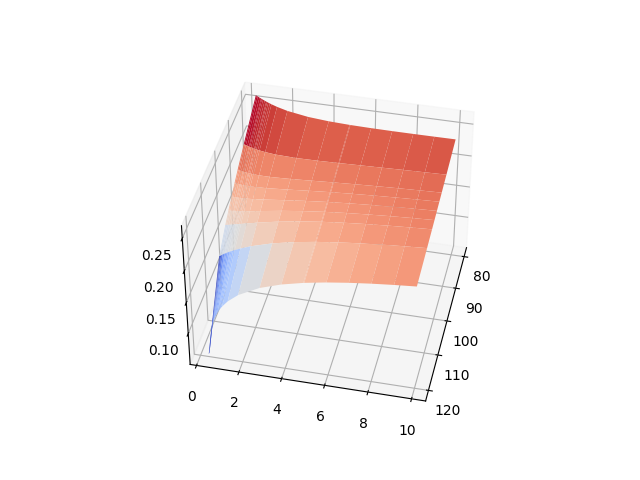

In [38]:
%matplotlib notebook

P_cal = np.zeros((N_T, len(K)))
IV_cal = np.zeros((N_T, len(K)))

for j in range(N_T):
    P_cal[j,:] = Heston.analytic_hest(S0, K, maturities[j], r, q, kappa, theta, rho, eta, sigma_0, options_type)
    IV_cal[j,:] = BlackScholes.BSImpliedVol(S0, K, maturities[j], r, q, P_cal[j,:], Option_type = 1, toll = 1e-5)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
mesh_x, mesh_y = np.meshgrid(moneyness,maturities[30:])
surf = ax.plot_surface(mesh_x, mesh_y, IV_cal[30:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
plt.show()

<IPython.core.display.Javascript object>


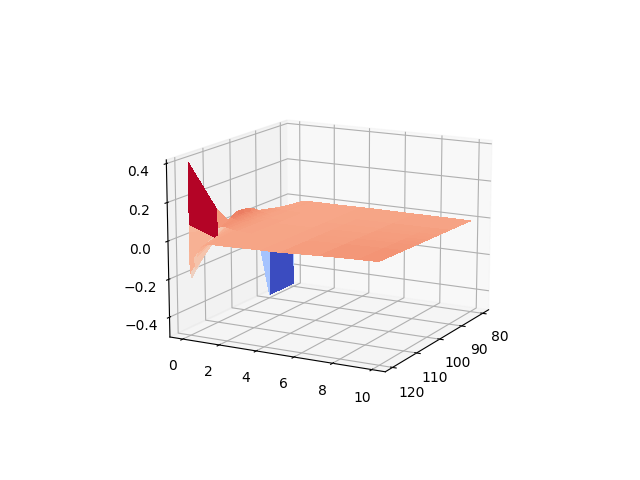

In [39]:
%matplotlib notebook
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
mesh_x, mesh_y = np.meshgrid(moneyness,maturities)
surf = ax.plot_surface(mesh_x, mesh_y, IV_cal-IV, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [44]:
maturities[30]

0.394520548

In [45]:
0.39*360

140.4